In [1]:
import torch
import pickle
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

#### Explore attenion maps

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


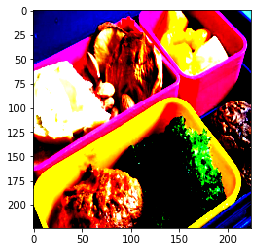

In [2]:
train_img = torch.load("cached_data/train_img")

print(train_img[0].size())
plt.imshow(np.fliplr((train_img[0].permute(1, 2, 0))))
plt.show()

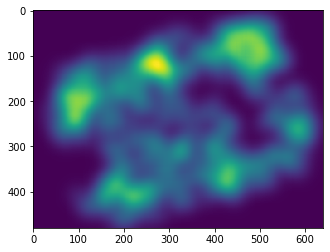

torch.Size([224, 224])


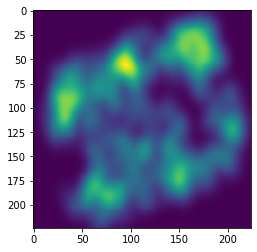

In [65]:
image_map  = 'dataset/maps/train/COCO_train2014_000000000009.png'

img = Image.open(image_map)
plt.imshow(img)
plt.show()
normalize = transforms.Normalize(mean=[0.485],
                                 std=[0.229])
transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

mask = transform(img).squeeze()
print(mask.size())

plt.imshow(mask)


torch.Size([3, 224, 224])


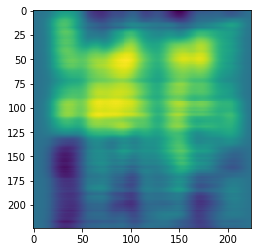

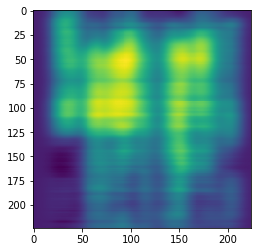

In [95]:
result1 = torch.matmul(train_img[0],mask)
result2 = torch.matmul(1 + train_img[0],mask)

print(result1.size())
## output for specific channel
plt.imshow(result1.permute(1, 2, 0)[:,:,0]) 
plt.show()
plt.imshow(result2.permute(1, 2, 0)[:,:,0])

#### Extract feature maps

In [5]:
import vision_network
device = "cuda:0"
vision_net = vision_network.VisionNet(device)

timeline = "20191219-111227"
vision_net.model.load_state_dict(torch.load("models/enc1-%s" % timeline))
# model = torch.load("models/enc1-%s" % timeline)

<All keys matched successfully>

In [96]:
print(vision_net.model._modules.get('layer1'))
# print (vision_net.model)

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, ke

In [7]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

torch.Size([64, 256, 56, 56])


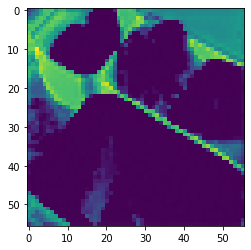

In [8]:
train_set = train_img[0:64]
# print(train_set.size())
# print(vision_net.forward(train_set.to(device)).size())

# print (vision_net.model)
vision_net.model.layer1.register_forward_hook(get_activation('layer1'))
output = vision_net.model(train_set.to(device))
# layer = model._modules.get('layer3')
print(activation['layer1'].size())

plt.imshow(activation['layer1'][0,0,:,:].cpu()) 
plt.show()


torch.Size([64, 256, 56, 56])


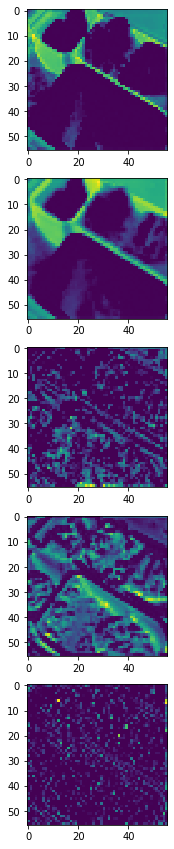

In [87]:
act = activation['layer1'].squeeze().cpu()
print(act.size())
fig, axarr = plt.subplots(5,figsize=(15,15))
for idx in range(5):
    axarr[idx].imshow(act[0,idx,:,:]) 

torch.Size([56, 56])


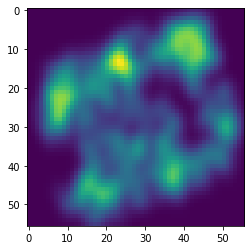

In [101]:
transform2 = transforms.Compose([
            transforms.Resize((56, 56)),
            transforms.ToTensor(),
        ])

mask2 = transform2(img).squeeze()
print(mask2.size())

plt.imshow(mask2)


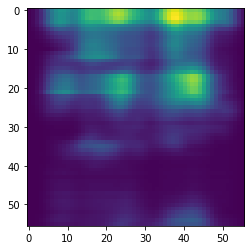

In [97]:
plt.imshow(torch.matmul(act[0][0],mask2))